# Vision Transformer

In this notebook we will implement and use [Brian Pulfer's](https://www.brianpulfer.ch/blog/vit) Vision Transformer, which is based on the original paper's implementation,
found [here](https://arxiv.org/abs/2010.11929).

<img src="https://github.com/jgenc/vit-research/blob/main/resources/ViT_Steps.png?raw=1" alt="Patches" width="1000"/>

Image source: https://arxiv.org/abs/2202.06709

We will implement the model in the following steps:
1. Transform input image into patches
2. Use Linear Mapping to create tokens from the patches
3. Create trainable classification token
4. Add positional embedding to each token
5. Embedding Layer
6. Classification

Before we continue we will need to download some Python files including
helpful tooling functions, such as plotting, the train loop, etc.
If the project is cloned locally, uncomment the commented lines and comment the
lines starting with an exclamantion point. The repository is found [here](https://github.com/jgenc/vit-research).

In [1]:
# Uncomment if running on local machine
# %pip install venv
# !python3 -m venv .venv
# %pip install -r requirements.txt

!mkdir utils
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/patchifying.py > ./utils/patchifying.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/train_loop.py > ./utils/train_loop.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/plotting.py > ./utils/plotting.py

mkdir: cannot create directory ‘utils’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   337  100   337    0     0    666      0 --:--:-- --:--:-- --:--:--   666
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2825  100  2825    0     0  10609      0 --:--:-- --:--:-- --:--:-- 10620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2974  100  2974    0     0  10022      0 --:--:-- --:--:-- --:--:-- 10047


In [37]:
import torch
from torchvision.models import VisionTransformer
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange

from utils.plotting import plot_results, show_metrics, save_metrics, plot_results
from utils.train_loop import train_loop
from utils.patchifying import show_patches

## Step 0: Dataset

We will use the **MNIST** dataset, which contains $28 \times 28$ grayscale images.
More info about the dataset can be found [here](https://en.wikipedia.org/wiki/MNIST_database).

The class `torchvision.dataset.mnist.MNIST()` contains tuple objects of images
and the target label, in the `(img, target)` format. `img` is a [PIL image](https://python-pillow.org/). Currently the images are not in the format PyTorch needs,
therefore we use the `torchvision.transforms.ToTensor()` class, which transforms an image to a Tensor.

In [3]:
transform = ToTensor()

train_set = MNIST(root="./data", train=True, download=True, transform=transform)
test_set = MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 60000, Test set size: 10000


The training split of the dataset contains $60.000$ images, while the test
set contains $10.000$ images.

We also need to create a dataloader for each split of the dataset. It handles
the data loading using an iterator (which happens iteratively, meaning the whole dataset is not
loaded at one time, only `batch_size` images are loaded into memory).

The `shuffle` parameter is also useful, it randomly shuffles the dataset
on each epoch.

In [4]:
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

The following cells prints an image from the train dataset.

We can change the printed image by changing the number of the index variable.

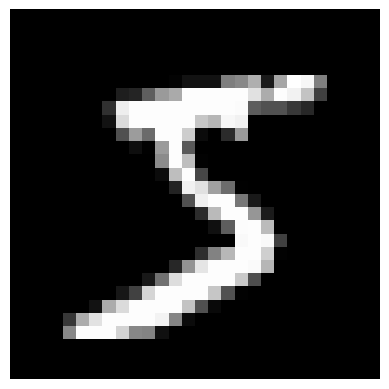

In [5]:
index = 0                       # From 0 to 59.999
image = train_set[index][0]
image = image.transpose(0, 1).transpose(1, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")

## Step 1: Creating Patches

To create the patches we need to pick a value for the $p$ parameter. This process
will create $m$ patches, where $$ m = \frac{hw}{p^2} $$

Our dataset has a size of $(60.000, 1, 28, 28)$. We will use $p=4$, and the number
of patches will be $m=49$.

The size dimensions of each patch are $p \times p$, in our case $4 \times 4$.
Each image will be broken down into a $\sqrt{m} \times \sqrt{m}$ grid, in our case
the grid will be $7 \times 7$.

After these transfromations, the dataset will have a size of $(60.000, 7, 7, 4, 4)$.
We need to flatten the dimensions of the grid and each patch into $(60.000, 49, 16)$.


<img src="./resources/Patches.png" alt="Patches" width="500"/>

The following cell shows how each image will be split into their patches.

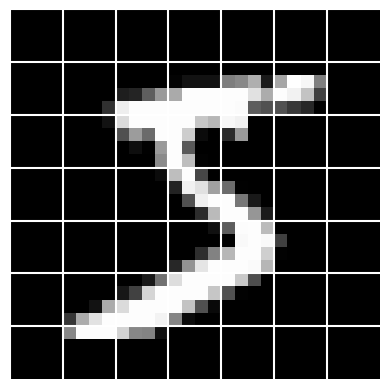

In [6]:
show_patches(image)

In [7]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.flatten(2, 3).flatten(3, 4).flatten(1, 2)
    return patches

## Step 2: Linear Embedding

Now we need to transform the patches into tokens, which is the same process as the
traditional [Transformer](https://arxiv.org/abs/1706.03762).

This step includes the tuning of the `hidden_d` parameter, which is a Hyper Parameter
of the model. In our simple training examples we will use a value of $8$.
There's also the `input_d` parameter, which is calculated with $p^2$. We chose
a value of $4$ for $p$, so `input_d` will have a value of $16$.

In [8]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        return tokens

## Step 3: Classification token \<cls\>

It's a learnable parameter of the model. We will need to add it to the tokens
we created in the previous step.

This token's size is `(1, hidden_d)`. If we add this to the tokens we have already
made, we will have a size of $(60.000, 50, 16)$ for the input.

We update the `MyVit` class with the \<cls\> token.

In [9]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        return tokens

## Step 4: Positional Encoding

The model up until now does not save the positional information
of each patch in the original image. However, that information is crucial for any
image task, as we would not like to return an image with jumbled patches.

To solve this we will create the positional embeddings of each token using the
sin and cos functions.

The following function needs the `sequence_length` and `hidden_d` parameters.
`sequence_length` is the number of tokens created for each image (which is $50$)
and `hidden_d` is a hyperparameter we defined earlier (which is $8$)

In [10]:
def get_positional_embeddings(sequence_length, hidden_d):
    result = torch.ones(sequence_length, hidden_d)

    for i in range(sequence_length):
        for j in range(hidden_d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / hidden_d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / hidden_d)))
            )
    return result

The following cell plots the positional embeddings using the values of our model.

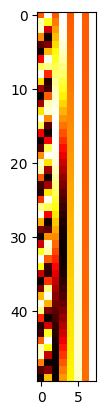

In [11]:
plt.imshow(get_positional_embeddings(49 + 1, 8), cmap="hot", interpolation="nearest")
plt.show()

We can increase the size of the parameters to see how the positional encodings
would look for bigger models.

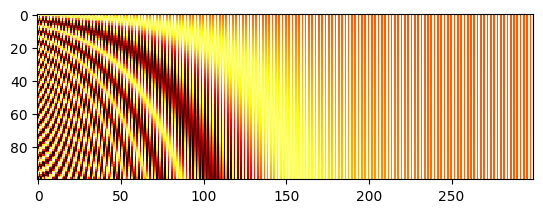

In [12]:
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

We update the `MyViT` class with the new functionality

In [13]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = torch.nn.Parameter(
            torch.tensor(
                get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d)
            )
        )
        self.pos_embed.requires_grad = False

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(n, 1, 1)

        out = tokens + pos_embed
        return out

## Step 5: Encoder Module

In this step we will impelement the following:

- Multi-Head Self-Attention (MSA)
- Multi-Layer Perceptron (MLP)

Before we apply each of these blocks we will create residual connetions and
pass the input through a Layer Normalisation layer.

In [14]:
class MyMSA(torch.nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()

        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)

        self.q_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )

        self.d_head = d_head
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)

        result = []

        for sequence in sequences:
            seq_result = []

            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]

                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))

                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [15]:
class MyViTBlock(torch.nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()

        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.norm1 = torch.nn.LayerNorm(hidden_d)

        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = torch.nn.LayerNorm(hidden_d)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_d, mlp_ratio * hidden_d),
            torch.nn.GELU(),
            torch.nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

We update the `MyVit` class with the Encoder block

In [16]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

    def forward(self, images):
        # Dividing images into patches

        n, c, h, w = images.shape

        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

## Step 6: Classification

The task of this notebook is to correctly classify the hand-drawn numbers of
the MNIST dataset.

We have 10 possible classes, meaning the output of the model will need to output
10 propabilities. We achieve this by adding an MLP block at the end of the model,
with an output dimension of 10 and an input dimension of the previous layer.

With a different dataset, which contains a different number of classes, we will
need to update the output dimension accordingly.

In [17]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, num_layers=2, hidden_dim=8, num_heads=2, num_classes=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = num_layers
        self.n_heads = num_heads
        self.hidden_d = hidden_dim

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_dim),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_dim, num_heads) for _ in range(num_layers)]
        )

        # 5) Classification MLPk
        self.mlp = torch.nn.Sequential(torch.nn.Linear(self.hidden_d, num_classes), torch.nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

## Training the Vision Transformer on MNIST

Your environment might have a GPU, TPU or the MPS chip made by Apple.
If the accelerator device actually exists it would be better to train the model
on that device rather than on the CPU.

In [18]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")

Using device cuda


We create an instance of the model with values of the parameters we used in the
previous cells.

We can experiment with different values for each parameter. Notably:
- `num_layers` indicates the number of encoder blocks containing the MSA and MLP blocks
- `hidden_d` is used to change the dimensionality of the hidden layers
- `num_heads` is the parameter which indicates how many parallel multiplications
will be computed on the Q, K, V matrices. In the Figure 2 at the start of the
model you can look at the $(c)$ part
- `num_classes` is the number that handles the output dimension size. As we said
before, this number depends on the task and the dataset used

In [19]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

In [21]:
model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_classes=num_classes, 
).to(device)

We need to pick a number of epochs and the Learing rate, just like every
Deep Learning project

In [22]:
N_EPOCHS = 5
LR = 5e-3

In [23]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    30,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 2.04, Train accuracy: 41.27%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.89
Test accuracy: 57.06%


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 
Train loss: 1.84, Train accuracy: 61.62%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.81
Test accuracy: 65.07%


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 
Train loss: 1.80, Train accuracy: 65.70%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.78
Test accuracy: 67.65%


Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 
Train loss: 1.79, Train accuracy: 67.44%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.74
Test accuracy: 71.85%


Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 
Train loss: 1.74, Train accuracy: 72.40%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.74
Test accuracy: 72.09%


We need to look at the performance of the model as the epochs go on, so that we can
see if the model is actually learning. We will plot the Accuracy and Loss curves.

For the following cell to work the previous cell has to have finished, which can
take a while depending on what device the model is trained on.

Each training run will save the output in the `metrics` local folder. If you
want to plot specific run results than uncomment the `show_metrics` line and
change the parameter to the run you want to plot.

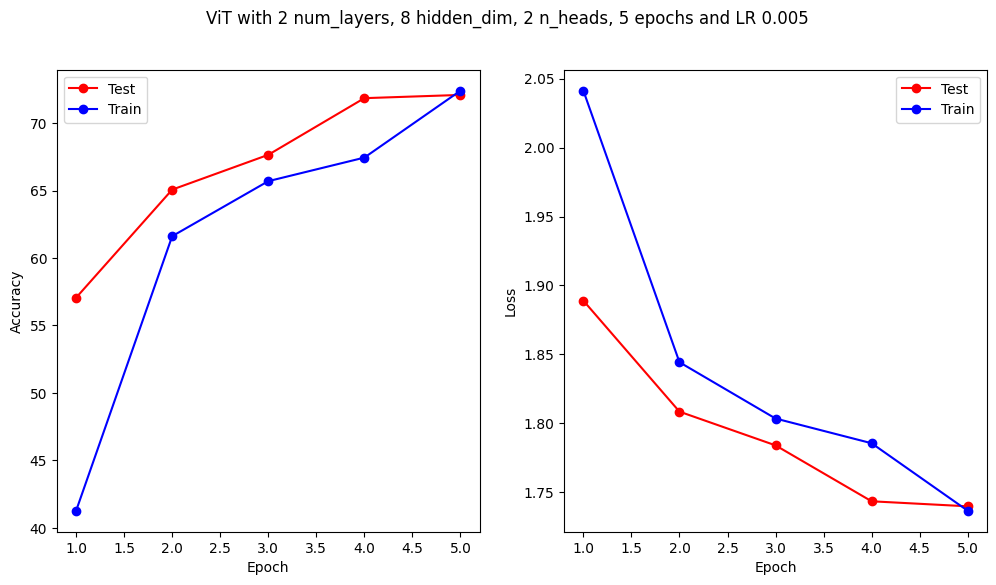

In [24]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

# show_metrics("./metrics/23-12-07_21-15-28_metrics.npz")

Notice that the model we trained performs better on the test set rather than
on the train set. This is not normal behaviour. Our implementation of the Vision
Transformer does not implement standard techniques of machine learning, such as
Dropout.

In the following cells we will try out PyTorch's implementation of ViT.

We can change and try out different values for the following parameters, or we
can run the model with the parameters as is. 

There's also the option of training
the model with PyTorch's default parameters. It can be done by uncommenting the
line with no given parameters. Note that it will take much more time to train.

In [43]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

mlp_dim = 30
dropout = 0.1

N_EPOCHS = 5
LR = 5e-3

patch_size = 4     # This is the p parameter we used earlier
image_size = 28    # MNIST image size is 28x28

Grayscale images won't work on PyTorch's Vision Transformer, because the size of the images
are $(N, 1, 28, 28)$. The model needs input images of 3 dimensions. We need to transform
the dataset into the following size:
$$
(N, 3, 28, 28)
$$

To achieve this, we need to modify the dataset and add one more transformation, in addition
to the `toTensor()` one.

`Grayscale` transforms an image to graysclale, with an output channel size from 1 to 3.

In [44]:
from torchvision.transforms import Grayscale, Compose

transforms = Compose([
    Grayscale(3),
    ToTensor(),
])

train_set = MNIST(root='./data', train=True, download=True, transform=transforms)
test_set = MNIST(root='./data', train=False, download=True, transform=transforms)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

# Default Parameters
# model = VisionTransformerGrayscale().to(device)

In [47]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 1.60, Train accuracy: 38.18%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.23
Test accuracy: 56.01%


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 
Train loss: 1.02, Train accuracy: 64.01%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.99
Test accuracy: 66.16%


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 
Train loss: 0.87, Train accuracy: 70.30%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.80
Test accuracy: 73.11%


Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 
Train loss: 0.76, Train accuracy: 74.82%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.73
Test accuracy: 76.12%


Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 
Train loss: 0.69, Train accuracy: 77.41%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.66
Test accuracy: 78.55%


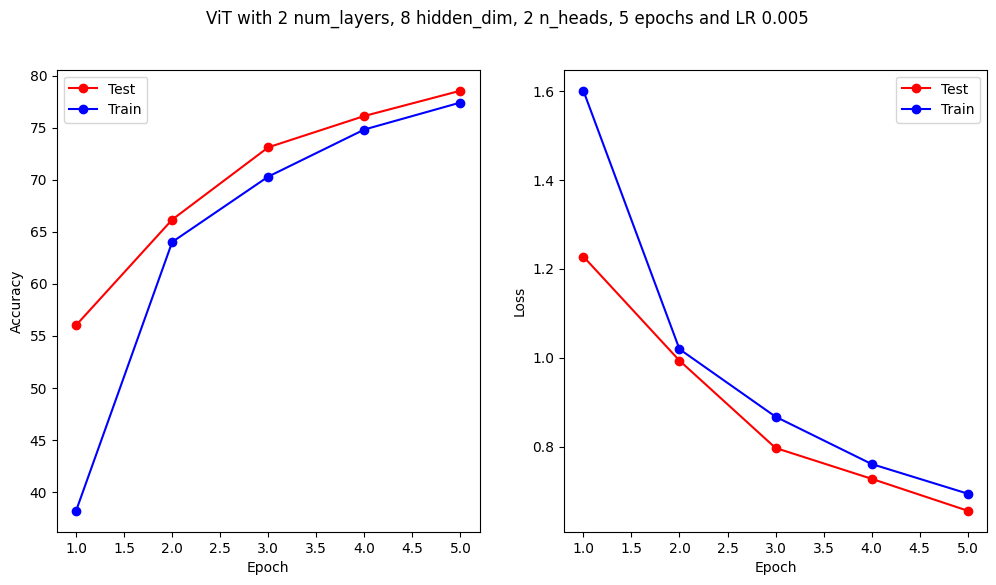

In [48]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

We can see that the model's accuracy and loss is not very stable. Also, the
training time was significantly less than our previous implementation (this allows
us to try and train the model with bigger hyperparameters)

We will train the model for more epochs and we will modify model's parameters.

In [50]:
num_layers = 6
hidden_dim = 30
num_heads = 6
mlp_dim = 40
dropout = 0.1
num_classes = 10

patch_size = 4
image_size = 28 

N_EPOCHS = 20
LR = 5e-3

model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

In [51]:
metrics = train_loop(
    model,
    train_loader,
    test_loader,
    device,
    num_layers,
    
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
)

train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric = metrics

Training:   0%|                                                                                                                                    | 0/20 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

The model is now much more stable and approaches the 100% accuracy rate.

Let's try and see what the model predicts from a random image in the train dataset.
You can try and change the index to another image. Remember, there are 10.000 images
in that set.

Model predicted class 4


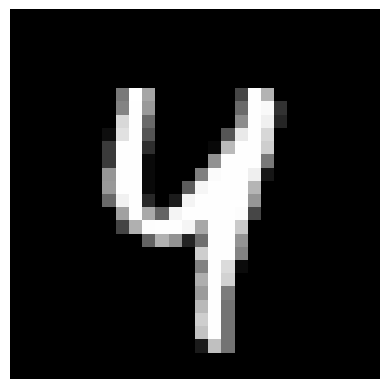

In [59]:
index = 42                                                                                                                                                                      
image, label = test_loader.dataset[index]

plt.axis("off")
plt.imshow(image.transpose(0, 2).transpose(0, 1), cmap="gray")

prediction = model(image.unsqueeze(0).to(device))
print(f"Model predicted class {torch.argmax(prediction).item()}")

With the help of external applications (such as GIMP) we can draw our own images.
I've prepared one such image, which you can see in the next cell.

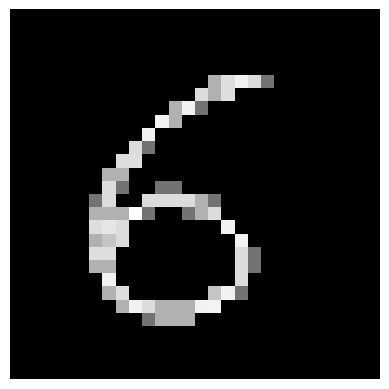

In [60]:
from PIL import Image

our_image = Image.open("./test.png").convert("L")
plt.axis("off")
plt.imshow(our_image, cmap="gray")

It's a 6. Now we can pass this image to our trained model and see if it will correctly
classify it.

In [ ]:
model.eval()
pred = model(transform(our_image).unsqueeze(0).to(device))

print(f"Model predicted class {torch.argmax(pred).item()}")